In [15]:
%pip install torch
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from tqdm import trange  
import pandas as pd 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
# 1. Load CSV
csv_path = "../data/raw/tennis-m-shots-rg.csv"  
df = pd.read_csv(csv_path)

# Replace NaN with a string so LabelEncoder can handle them
df = df.fillna("NA")

# 2. Encode categorical features

encoders = {}

categories = [
    'ShotHand',
    'ShotType',
    'ServeDirection',
    'ShotDirection',
    'ShotDepth',
    'OutcomeType',
    'ErrorType',
]

for col in categories:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    encoders[col] = le

# Feature columns for the model (shot-level)
# "Shot" is numeric already and acts as a positional feature
feature_cols = [col + '_encoded' for col in categories] + ['Shot']

print("Feature columns used:", feature_cols)


rally_cols = ['Date', 'Tournament', 'Player1', 'Player2', 'Point']
K = 10 # number of shots we condition on

X_list = []
y_list = []

for _, grp in df.groupby(rally_cols):
    # Ensure shots are in order
    grp = grp.sort_values('Shot')

    # Need at least K+1 shots in the rally to define "next shot"
    if len(grp) <= K:
        continue

    # First K shots as input features
    seq_features = grp[feature_cols].iloc[:K].values.astype('float32')  # (K, F)

    # ShotType of the (K+1)-th shot as label
    next_shottype_encoded = int(grp['ShotType_encoded'].iloc[K])

    X_list.append(seq_features)
    y_list.append(next_shottype_encoded)

# Stack into arrays
X_next = np.stack(X_list, axis=0)               # (N, K, F)
y_next = np.array(y_list, dtype=np.int64)       # (N,)

print("X_next shape:", X_next.shape)  # (num_examples, K, num_features)
print("y_next shape:", y_next.shape)  # (num_examples,)

num_shottype_classes = df['ShotType_encoded'].nunique()
print("Number of ShotType classes:", num_shottype_classes)

# Print distribution over original ShotType (encoded)
shottype_le = encoders['ShotType']
counts_next = Counter(y_next)

print("\nNext-shot distribution by original ShotType:")
for encoded_label, count in sorted(counts_next.items()):
    label_name = shottype_le.inverse_transform([encoded_label])[0]
    print(f"{encoded_label:2d} ({label_name:16s}) -> {count}")


# 4. Group ShotTypes into coaching categories
# Groups:
#  - groundstroke
#  - slice
#  - drop_shot
#  - serve
#  - volley_group      = {volley, half_volley, swinging_volley}
#  - lob_overhead      = {lob, overhead}
#  - NA and anything unexpected are dropped

volley_group = {"volley", "half_volley", "swinging_volley"}
lob_overhead_group = {"lob", "overhead"}
keep_single = {"groundstroke", "slice", "drop_shot", "serve"}

group_names = []   # labels per example
keep_mask = []     # which examples to keep (exclude NA, etc.)

for y in y_next:
    st_name = shottype_le.inverse_transform([y])[0]
    
    if st_name == "NA":
        keep_mask.append(False)
        group_names.append(None)
        continue
    
    if st_name in volley_group:
        g = "volley_group"
    elif st_name in lob_overhead_group:
        g = "lob_overhead"
    elif st_name in keep_single:
        g = st_name
    else:
        # anything unexpected, drop
        keep_mask.append(False)
        group_names.append(None)
        continue
    
    keep_mask.append(True)
    group_names.append(g)

keep_mask = np.array(keep_mask, dtype=bool)

# Filter X and names
X_group = X_next[keep_mask]
group_names = [g for g in group_names if g is not None]

print("\nAfter grouping & dropping NA/unexpected:")
print("X_group shape:", X_group.shape)
print("Num grouped labels:", len(group_names))

# Encode grouped labels into integers
group_le = LabelEncoder()
y_group = group_le.fit_transform(group_names)

print("Grouped classes:", list(group_le.classes_))
print("Grouped next-shot counts:", Counter(y_group))

# 5. Save data + encoders
# Original 10-class next-shot labels
np.save("X_next_shottype.npy", X_next)
np.save("y_next_shottype.npy", y_next)

# Grouped 6-class next-shot labels
np.save("X_next_grouped.npy", X_group)
np.save("y_next_grouped.npy", y_group)




Feature columns used: ['ShotHand_encoded', 'ShotType_encoded', 'ServeDirection_encoded', 'ShotDirection_encoded', 'ShotDepth_encoded', 'OutcomeType_encoded', 'ErrorType_encoded', 'Shot']
X_next shape: (9350, 10, 8)
y_next shape: (9350,)
Number of ShotType classes: 10

Next-shot distribution by original ShotType:
 0 (NA              ) -> 12
 1 (drop_shot       ) -> 190
 2 (groundstroke    ) -> 7304
 3 (half_volley     ) -> 40
 4 (lob             ) -> 191
 5 (overhead        ) -> 122
 6 (serve           ) -> 25
 7 (slice           ) -> 1120
 8 (swinging_volley ) -> 30
 9 (volley          ) -> 316

After grouping & dropping NA/unexpected:
X_group shape: (9338, 10, 8)
Num grouped labels: 9338
Grouped classes: ['drop_shot', 'groundstroke', 'lob_overhead', 'serve', 'slice', 'volley_group']
Grouped next-shot counts: Counter({1: 7304, 4: 1120, 5: 386, 2: 313, 0: 190, 3: 25})


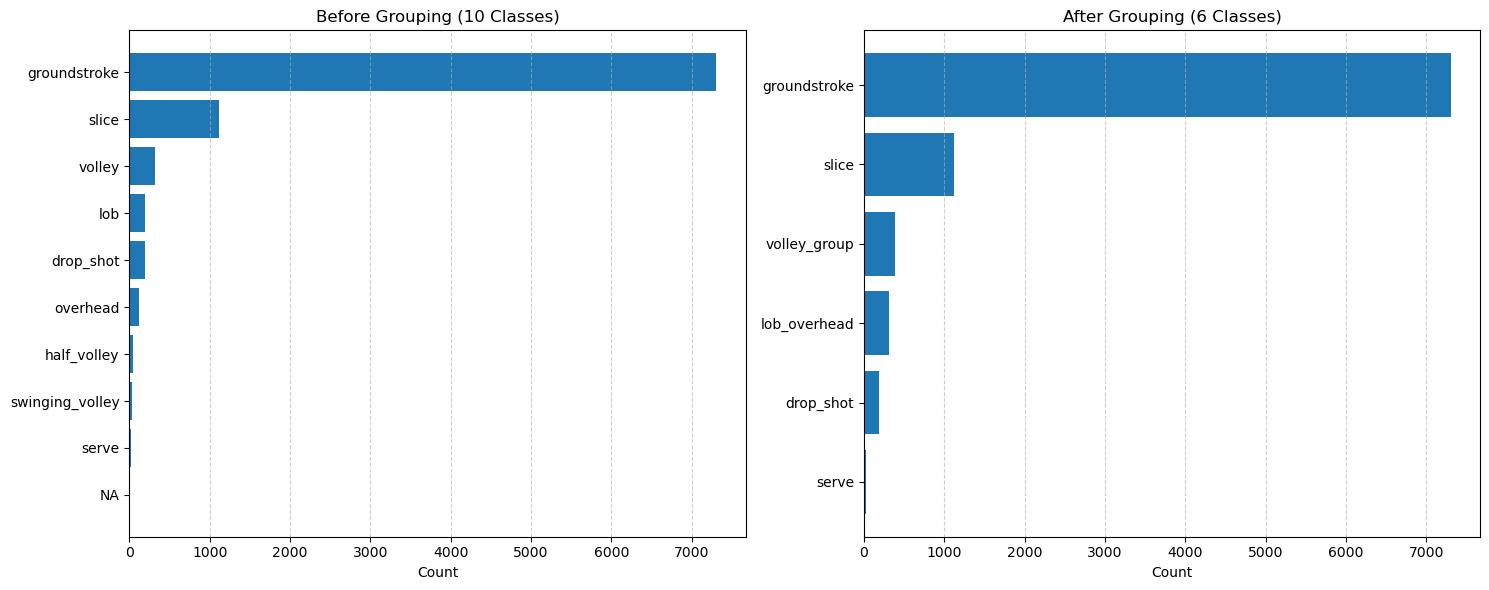

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------------
# 1. Original class counts
# -----------------------------------
orig_counts = Counter(y_next)
orig_names = [shottype_le.inverse_transform([k])[0] for k in orig_counts.keys()]
orig_vals = [orig_counts[k] for k in orig_counts.keys()]

# Sort original
orig_pairs = sorted(zip(orig_vals, orig_names))
orig_vals_sorted, orig_names_sorted = zip(*orig_pairs)

# -----------------------------------
# 2. Grouped class counts
# -----------------------------------
group_counts = Counter(y_group)
group_names = list(group_le.classes_)
group_vals = [group_counts[i] for i in range(len(group_names))]

# Sort grouped
group_pairs = sorted(zip(group_vals, group_names))
group_vals_sorted, group_names_sorted = zip(*group_pairs)

# -----------------------------------
# 3. Plot side-by-side horizontal bars
# -----------------------------------
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.barh(orig_names_sorted, orig_vals_sorted)
plt.title("Before Grouping (10 Classes)")
plt.xlabel("Count")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.barh(group_names_sorted, group_vals_sorted)
plt.title("After Grouping (6 Classes)")
plt.xlabel("Count")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [18]:
# 1. Load grouped data
X_group = np.load("X_next_grouped.npy")   # (9338, 10, 8)
y_group = np.load("y_next_grouped.npy")   # (9338,)

print("X_group shape:", X_group.shape)
print("y_group shape:", y_group.shape)

# We know from preprocessing that the classes are:
class_names = ['drop_shot', 'groundstroke', 'lob_overhead', 'serve', 'slice', 'volley_group']
num_classes = len(class_names)

# 2. Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_group, y_group,
    test_size=0.2,
    random_state=42,
    stratify=y_group
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 3. Dataset + DataLoader
class NextShotGroupDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, 10, 8)
        self.y = torch.tensor(y, dtype=torch.long)     # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NextShotGroupDataset(X_train, y_train)
test_dataset  = NextShotGroupDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_size = X_group.shape[2]   # 8
hidden_size = 64

# 4. LSTM model
class NextShotTypeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.firstLayer = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, num_classes)
    def forward(self, x):
        _, (h, c) = self.lstm(x)
        x = torch.relu(self.firstLayer(h.squeeze(0)))
        return self.output(x)   # logits

model = NextShotTypeLSTM(input_size, hidden_size, num_classes)

# 5. Class-balanced loss for rare classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 6. Training loop

num_epochs = 50
for epoch in trange(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

X_group shape: (9338, 10, 8)
y_group shape: (9338,)
Train shape: (7470, 10, 8) Test shape: (1868, 10, 8)


 20%|██        | 10/50 [00:04<00:20,  1.98it/s]

Epoch 10/50 - Train Loss: 0.7270


 40%|████      | 20/50 [00:08<00:12,  2.36it/s]

Epoch 20/50 - Train Loss: 0.4417


 60%|██████    | 30/50 [00:13<00:08,  2.44it/s]

Epoch 30/50 - Train Loss: 0.3677


 80%|████████  | 40/50 [00:17<00:03,  2.51it/s]

Epoch 40/50 - Train Loss: 0.3388


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]

Epoch 50/50 - Train Loss: 0.2891


In [19]:
# 7. Evaluation (Top-1 and Top-2 accuracy)
model.eval()
all_true = []
all_pred_top1 = []

correct_top1 = 0
correct_top2 = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)                      

        # Top 1 prediction
        top1_pred = torch.argmax(logits, dim=1)      

        # Top 2 
        top2_vals, top2_idx = torch.topk(logits, k=2, dim=1)   #

        # Update counters
        total += y_batch.size(0)
        correct_top1 += (top1_pred == y_batch).sum().item()
        # True if label is in {top1, top2}
        correct_top2 += ((top2_idx[:, 0] == y_batch) | (top2_idx[:, 1] == y_batch)).sum().item()

        # Save for classification report (top-1 only)
        all_true.extend(y_batch.cpu().numpy())
        all_pred_top1.extend(top1_pred.cpu().numpy())

top1_acc = correct_top1 / total
top2_acc = correct_top2 / total

print(f"\nTop-1 Accuracy (grouped ShotType): {top1_acc:.3f}")
print(f"Top-2 Accuracy (grouped ShotType): {top2_acc:.3f}")

from sklearn.metrics import classification_report
print("\nClassification report (Top-1 predictions, grouped labels):")
print(classification_report(all_true, all_pred_top1, target_names=class_names))



Top-1 Accuracy (grouped ShotType): 0.526
Top-2 Accuracy (grouped ShotType): 0.893

Classification report (Top-1 predictions, grouped labels):
              precision    recall  f1-score   support

   drop_shot       0.07      0.21      0.10        38
groundstroke       0.87      0.54      0.67      1461
lob_overhead       0.29      0.41      0.34        63
       serve       1.00      0.80      0.89         5
       slice       0.19      0.52      0.28       224
volley_group       0.23      0.40      0.29        77

    accuracy                           0.53      1868
   macro avg       0.44      0.48      0.43      1868
weighted avg       0.73      0.53      0.59      1868



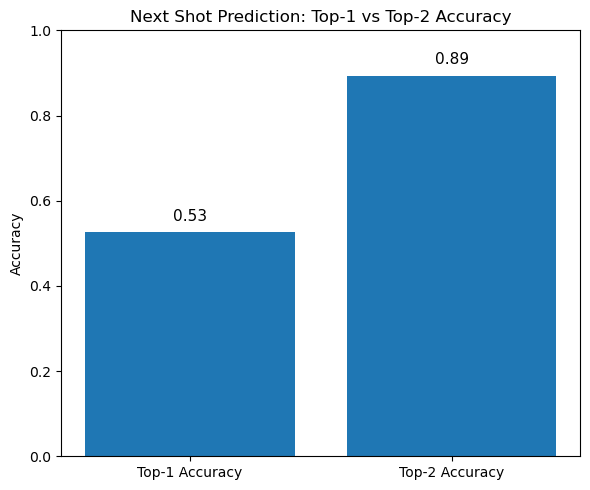

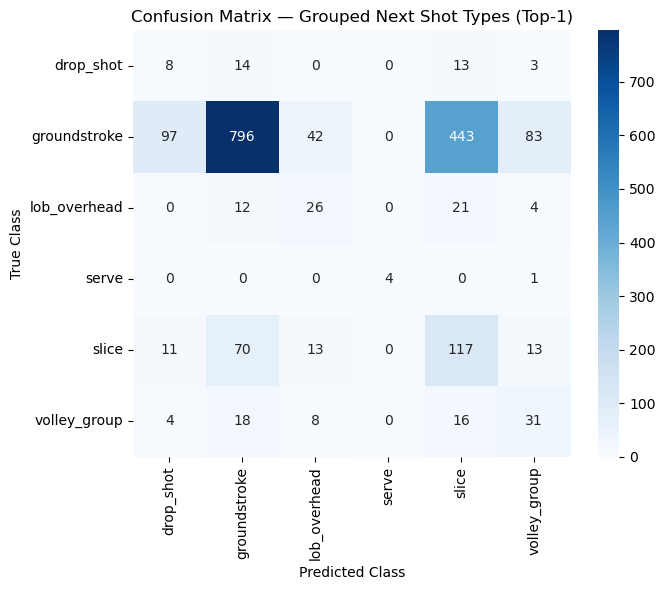

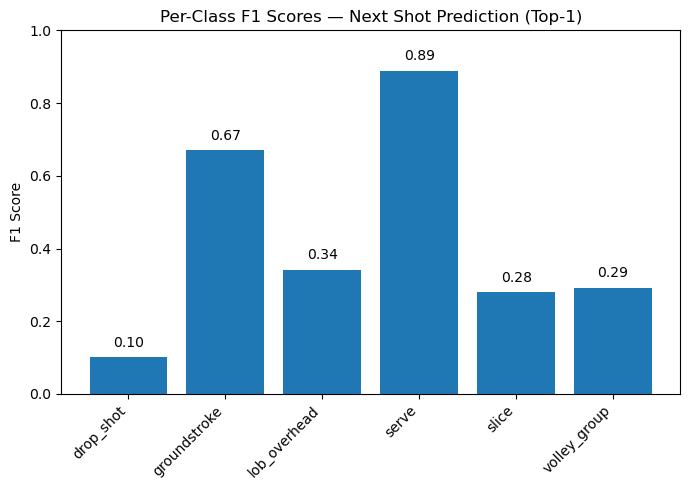

In [22]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
import seaborn as sns
plt.figure(figsize=(6, 5))
bars = plt.bar(
    ["Top-1 Accuracy", "Top-2 Accuracy"],
    [top1_acc, top2_acc]
)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Next Shot Prediction: Top-1 vs Top-2 Accuracy")

# Annotate bars with values
for bar, val in zip(bars, [top1_acc, top2_acc]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.02,
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 3. Slide C, Plot 2: Confusion Matrix (Top-1 Predictions)
# ------------------------------------------------------
cm = confusion_matrix(all_true, all_pred_top1)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix — Grouped Next Shot Types (Top-1)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 4. Slide C, Plot 3: Per-Class F1 Scores (Bar Chart)
# ------------------------------------------------------
report_dict = classification_report(
    all_true,
    all_pred_top1,
    target_names=class_names,
    output_dict=True
)

# Convert to DataFrame and keep only the 6 classes (drop avg rows)
df_report = pd.DataFrame(report_dict).T
df_classes = df_report.iloc[:len(class_names)]  # first 6 rows

plt.figure(figsize=(7, 5))
bars = plt.bar(df_classes.index, df_classes["f1-score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.title("Per-Class F1 Scores — Next Shot Prediction (Top-1)")

# Annotate each bar
for bar, val in zip(bars, df_classes["f1-score"].values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.02,
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()